In [2]:
#!apt install -qq enchant
#!pip install pyenchant
#!pip install pyspellchecker
#!pip install transformers
#!pip install conllu
#!pip install ufal.udpipe

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from gensim.models import KeyedVectors
from transformers import BertModel, BertTokenizer, GPT2Model, GPT2Tokenizer
from tqdm import tqdm_notebook
from math import ceil

import re
import os
import html
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pickle

import nltk
#nltk.download('punkt')
from nltk import word_tokenize

#from google.colab import drive

In [ ]:
!pip uninstall scikit-learn
!pip install scikit-learn==0.21.2

In [ ]:
!git clone https://github.com/lcl-hse/lab_inspector.git

In [ ]:
os.listdir('lab_inspector')

In [3]:
class MyBatchIterator:
  def __init__(self, texts, batch_size):
    self.texts = texts
    self.batch_size = batch_size
  
  def __iter__(self):
    self.start = 0
    return self
  
  def __next__(self):
    if self.start >= len(self.texts):
      raise StopIteration
    batch = self.texts[self.start:self.start+self.batch_size]
    self.start += self.batch_size
    return batch
  
  def __len__(self):
    return ceil(len(self.texts)/self.batch_size)

class BERTEmbedder:
  def __init__(self, model_name):
    self.tokenizer = BertTokenizer.from_pretrained(model_name)
    self.model = BertModel.from_pretrained(model_name)
  
  def process(self, texts, flatten_method='pooler'):
    tokenized = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    ids = tokenized['input_ids']
    mask = tokenized['attention_mask']
    processed = self.model(input_ids=ids, attention_mask=mask)

    if flatten_method == 'average':
      return processed['last_hidden_state'].detach().numpy().mean(axis=1)
    elif flatten_method == 'pooler':
      return processed['pooler_output'].detach().numpy()
  
  def process_sample(self, texts, batch_size=4, flatten_method='pooler'):
    text_iter = MyBatchIterator(texts, batch_size=batch_size)
    batches = []

    for batch in tqdm_notebook(text_iter, total=len(text_iter)):
      batches.append(self.process(batch, flatten_method=flatten_method))
    
    return np.concatenate(batches, axis=0)

class GPT2Embedder(BERTEmbedder):
  def __init__(self, model_name):
    self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    self.tokenizer.pad_token = self.tokenizer.eos_token
    self.model = GPT2Model.from_pretrained(model_name)
  
  def process(self, texts, flatten_method='pooler'):
    tokenized = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    ids = tokenized['input_ids']
    mask = tokenized['attention_mask']
    processed = self.model(input_ids=ids, attention_mask=mask)

    if flatten_method == 'average':
      return processed['last_hidden_state'].detach().numpy().mean(axis=1)
    elif flatten_method == 'pooler':
      return processed['pooler_output'].detach().numpy()

In [ ]:
drive.mount("/content/drive")

In [3]:
zero_level = pd.read_csv("ZeroLevel.csv")

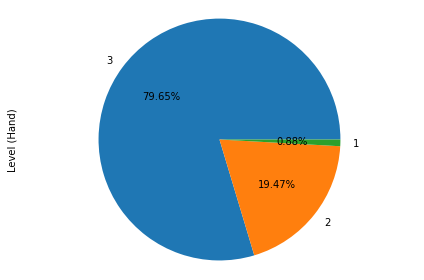

In [5]:
zero_level["Level (Hand)"].value_counts().plot.pie(autopct='%1.2f%%')
plt.axis("equal")
plt.tight_layout()
plt.show()

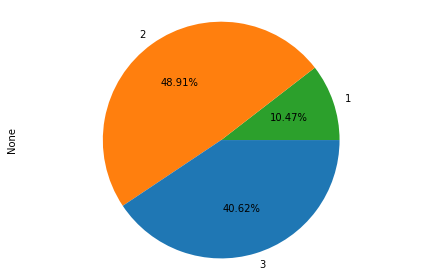

In [6]:
ml_data_class_counts = pd.Series({1: 67, 2:313, 3:260})
ml_data_class_counts.plot.pie(autopct='%1.2f%%',
                              colors=["#2ca02c",
                                      "#ff7f0e",
                                      "#1f77b4"])
plt.axis("equal")
plt.tight_layout()
plt.show()

In [4]:
zero_level

,Unnamed: 0,Unnamed: 0.1,id,Sentence (original),Sentence (changed),Right answer,Error type,Error type+,Level (Hand),path_in_REALEC,Sentence,Error span,LevelAuto
0,4,6,50904,If in North Africa and South Asia there <b>is...,If in North Africa and South Asia there <b>is...,were,Agreement_errors //Tense_choice,Agreement_errors,3,https://realec.org/index.xhtml#/exam/Exam2017/...,If in North Africa and South Asia there <b>is...,is,0
1,16,19,39505,"Overall, the chart gives information that aro...","Overall, the chart gives information that aro...",a bigger proportion,Comparison_degree,Comparison_degree,3,https://realec.org/index.xhtml#/exam/Exam2016/...,"Overall, the chart gives information that aro...",the biggest proportion,0
2,18,21,17497,The situation in Africa <b>is decreased</b> a...,The situation in Africa <b>was decreased</b> ...,worsened,Voice //lex_item_choice,Voice,3,https://realec.org/index.xhtml#/exam/Exam2016/...,The situation in Africa <b>was decreased</b> ...,was decreased,0
3,20,23,69626,"But on the other hand, there are a lot of <b>...",NaN,people who,Relative_clause,Relative_clause,3,https://realec.org/index.xhtml#/exam/Exam2017/...,"But on the other hand, there are a lot of <b>...","people, who",0
4,25,29,56370,<b>Exploration the space</b> can lead to the ...,<b>Exploration the space</b> can lead to new ...,Space exploration,Word_order //Article,Word_order,3,https://realec.org/index.xhtml#/exam/Exam2017/...,<b>Exploration the space</b> can lead to new ...,Exploration the space,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,718,813,55758,The most significant difference took place fo...,The most significant difference was registere...,three times as often as,Comparative_constr,Tense_choice,3,https://realec.org/index.xhtml#/exam/Exam2017/...,The most significant difference was registere...,three times more often than,0
109,730,826,4617,<b>USA's growth of elderly people percentage<...,NaN,The growth in the percentage of elderly people...,Structure_confusion,Word_order,3,https://realec.org/index.xhtml#/exam/Exam2014/...,<b>USA's growth of elderly people percentage<...,USA's growth of elderly people percentage,0
110,737,834,79712,The given pie charts present the major reasons...,The given pie charts present the major reasons...,a ten-year period,Structure_confusion //Article,Possessive,3,https://realec.org/index.xhtml#/exam/Exam2019/...,The given pie charts present the major reasons...,the ten year's period,0
111,741,838,80835,"Firstly, I believe that space could <b>wait</...","Firstly, I believe that space could wait <b>a...",until,Linking_device OR Conjunctions,Prepositions,3,https://realec.org/index.xhtml#/exam/Exam2017/...,"Firstly, I believe that space could wait <b>a...","a time, when",0


In [10]:
with open('BertEmbedder.pickle','rb') as inp:
  bert_embedder = pickle.load(inp)

# with open('GPT2Embedder.pickle','rb') as inp:
#   gpt2_embedder = pickle.load(inp)

# with open('BernoulliBERT.pickle','rb') as inp:
#   bernoulli_bert = pickle.load(inp)

# with open('BernoulliGPT2.pickle','rb') as inp:
#   bernoulli_gpt2 = pickle.load(inp)

FileNotFoundError: [Errno 2] No such file or directory: 'BernoulliBERT.pickle'

In [ ]:
with open('drive/My Drive/QuestionLevelPrediction/InspectorTree.pickle','rb') as inp:
  inspector_tree = pickle.load(inp)

In [7]:
X = zero_level["Sentence"].tolist()
y = zero_level["Level (Hand)"].apply(lambda x: f"adpq_{x}")

In [16]:
len(X)

113

In [8]:
X_bert = bert_embedder.process_sample(X, flatten_method="average")
#X_gpt2 = gpt2_embedder.process_sample(X, flatten_method="average")

c:\users\k1l77\desktop\182e~1\term_p~1\lib\site-packages\ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [9]:
y_pred_bert = bernoulli_bert.predict(X_bert)
#y_pred_gpt2 = bernoulli_gpt2.predict(X_gpt2)

NameError: name 'bernoulli_bert' is not defined

In [ ]:
print(classification_report(y, y_pred_bert))

In [ ]:
print(classification_report(y, y_pred_gpt2))

In [ ]:
os.chdir("lab_inspector/Inspector")

In [ ]:
from main import main as inspect

In [ ]:
X_inspector = []

for question in tqdm_notebook(X, total=len(X)):
  X_inspector.append(inspect(question))

X_inspector = pd.DataFrame(X_inspector, index=zero_level.index)

In [ ]:
X_inspector.head()

In [ ]:
y_pred_inspector = inspector_tree.predict(X_inspector)

In [ ]:
print(classification_report(y, y_pred_inspector))

In [ ]:
zero_level["Level (Hand)"] = zero_level["Level (Hand)"].apply(lambda x: f"adpq_{x}")

In [ ]:
zero_level["Level (ML)"] = y_pred_bert

In [ ]:
zero_level[zero_level["Level (Hand)"] == zero_level["Level (ML)"]]

In [ ]:
len(zero_level[zero_level["Level (Hand)"] == zero_level["Level (ML)"]])

In [ ]:
(388+53)/581

In [ ]:
import sklearn

In [11]:
with open('TreeBERT.pickle','rb') as inp:
  bert_tree = pickle.load(inp)

c:\users\k1l77\desktop\182e~1\term_p~1\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\k1l77\desktop\182e~1\term_p~1\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
y_pred_bert_tree = bert_tree.predict(X_bert)

In [13]:
print(classification_report(y, y_pred_bert_tree))

              precision    recall  f1-score   support

      adpq_1       0.00      0.00      0.00         1
      adpq_2       0.22      0.41      0.29        22
      adpq_3       0.82      0.56      0.66        90

    accuracy                           0.52       113
   macro avg       0.35      0.32      0.32       113
weighted avg       0.70      0.52      0.58       113



In [15]:
from sklearn.metrics import accuracy_score

In [18]:
print(accuracy_score(y, y_pred_bert_tree, normalize=False))

59


In [ ]:
zero_level["Level (ML)"] = y_pred_bert_tree

In [ ]:
len(zero_level[zero_level["Level (Hand)"] == zero_level["Level (ML)"]])

In [ ]:
(388+59)/581

In [23]:
with open("BertModel.pickle", 'wb') as outp1:
    pickle.dump(bert_embedder.model, outp1)

with open("BertTokenizer.pickle", 'wb') as outp2:
    pickle.dump(bert_embedder.tokenizer, outp2)

In [22]:
help(pickle.dump)

Help on built-in function dump in module _pickle:

dump(obj, file, protocol=None, *, fix_imports=True)
    Write a pickled representation of obj to the open file object file.
    
    This is equivalent to ``Pickler(file, protocol).dump(obj)``, but may
    be more efficient.
    
    The optional *protocol* argument tells the pickler to use the given
    protocol supported protocols are 0, 1, 2, 3 and 4.  The default
    protocol is 3; a backward-incompatible protocol designed for Python 3.
    
    Specifying a negative protocol version selects the highest protocol
    version supported.  The higher the protocol used, the more recent the
    version of Python needed to read the pickle produced.
    
    The *file* argument must have a write() method that accepts a single
    bytes argument.  It can thus be a file object opened for binary
    writing, an io.BytesIO instance, or any other custom object that meets
    this interface.
    
    If *fix_imports* is True and protocol is less